In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, LeaveOneOut, StratifiedKFold, cross_val_score, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
import random
import glob
import os


import warnings
warnings.filterwarnings('ignore')

In [3]:
loan_approval = pd.read_csv('./archive/Loan.csv')
loan_approval.shape

(20000, 36)

In [4]:
loan_approval['ApplicationDate'] = pd.to_datetime(loan_approval['ApplicationDate'])
loan_approval['ApplicationYear'] = loan_approval['ApplicationDate'].dt.year
loan_approval['ApplicationMonth'] = loan_approval['ApplicationDate'].dt.month
loan_approval = loan_approval.drop(columns=['ApplicationDate'])  #

In [5]:
X = loan_approval.drop(columns=['LoanApproved', 'RiskScore'])
y = loan_approval['LoanApproved']

In [6]:
categorical_cols = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 
                    'HomeOwnershipStatus', 'LoanPurpose']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

In [7]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),  # Normalize numerical data
        ('cat', OneHotEncoder(), categorical_cols)  # One-hot encode categorical data
    ])

In [8]:
X_preprocessed = preprocessor.fit_transform(X)

In [9]:
random_split = ShuffleSplit(n_splits=30, test_size=0.2)
kfold = KFold(n_splits=10, shuffle=True)
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True)
loo = LeaveOneOut()

In [11]:
def scores_split(model, X, y, cv=None, test_size=None, feature_selection=False):
    selector = SelectKBest(f_classif, k=5)
    if cv is None:
        if test_size is None:
            print("Not Using Train-Test Split")
            X_train = X
            X_test = X
            y_train = y
            y_test = y
        else:
            print("Using Train-Test Split")
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

            # Apply feature selection only to training data
        if feature_selection:
            X_train = selector.fit_transform(X_train, y_train)
            X_test = selector.transform(X_test)  # Transform test set using the same selector
            
        # Train the model on the training data
        model.fit(X_train, y_train)
        
        # Predict on the test data
        y_pred_test = model.predict(X_test)
        
        # Calculate and display performance metrics on the test set
        train_test_accuracy = accuracy_score(y_test, y_pred_test)
        train_test_f1 = f1_score(y_test, y_pred_test, average='weighted')
        train_test_recall = recall_score(y_test, y_pred_test)
        train_test_roc = roc_auc_score(y_test, y_pred_test)
        
        print('Accuracy: ',train_test_accuracy)
        print('F1: ',train_test_f1)
        print('Recall: ', train_test_recall)
        print('ROC: ', train_test_roc)
        
        # Plot confusion matrix for the test set
        display = ConfusionMatrixDisplay.from_estimator(
                    model, X_test, y_test, display_labels=[0, 1],
                    cmap=plt.cm.Blues, normalize='true')
        display.ax_.set_title("Confusion Matrix (Test Data)")
        
        plt.show()

    else:
        print(f"Using Cross-Validation with {cv} folds")

        steps = []
        if feature_selection:
            steps.append(('feature_selection', selector))

        steps.append(('model', model))
        pipeline = Pipeline(steps)
        
        # Cross-validation scoring
        scores = ['accuracy', 'f1_weighted', 'recall_weighted', 'roc_auc']
        colors = ['r', 'g', 'b', 'm']  # Different colors for each metric
        metric_results = {}
        
        for score in scores:
            if feature_selection:
                X = selector.fit_transform(X, y)
            cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=score)
            metric_results[score] = cv_scores  # Store the cross-validation scores
            print(f'{score}: {cv_scores.mean()}')

        plt.figure()
        
        for i, metric in enumerate(scores):
            plt.plot(range(1, len(metric_results[metric]) + 1),
                     metric_results[metric], label=metric.capitalize(),
                     color=colors[i])
            
        plt.title(f"Cross-Validation Scores ({cv} folds)")
        plt.xlabel("Fold Number")
        plt.ylabel("Score")
        plt.legend(loc="best")
        plt.grid(True)
        plt.show()

In [12]:
model = RandomForestClassifier(n_estimators=20)

Not Using Train-Test Split
Accuracy:  0.99895
F1:  0.9989493577955931
Recall:  0.9960251046025105
ROC:  0.9979468492789162


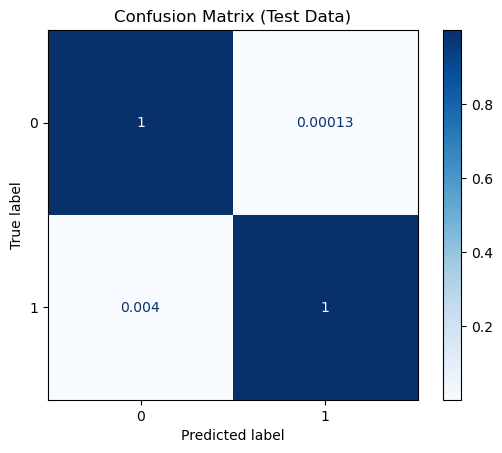

In [13]:
scores_split(model, X_preprocessed, y)

Using Train-Test Split
Accuracy:  0.915125
F1:  0.9131198258866116
Recall:  0.7636549259826442
ROC:  0.8639496281957584


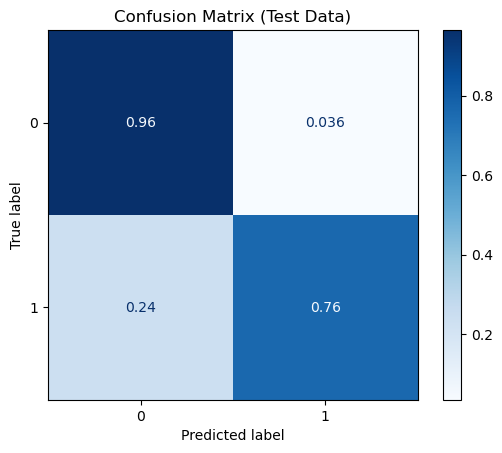

In [14]:
scores_split(model, X_preprocessed, y, test_size=0.4)

Using Cross-Validation with ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None) folds
accuracy: 0.9199166666666667
f1_weighted: 0.9167310465606445
recall_weighted: 0.9198333333333334
roc_auc: 0.970479824864905


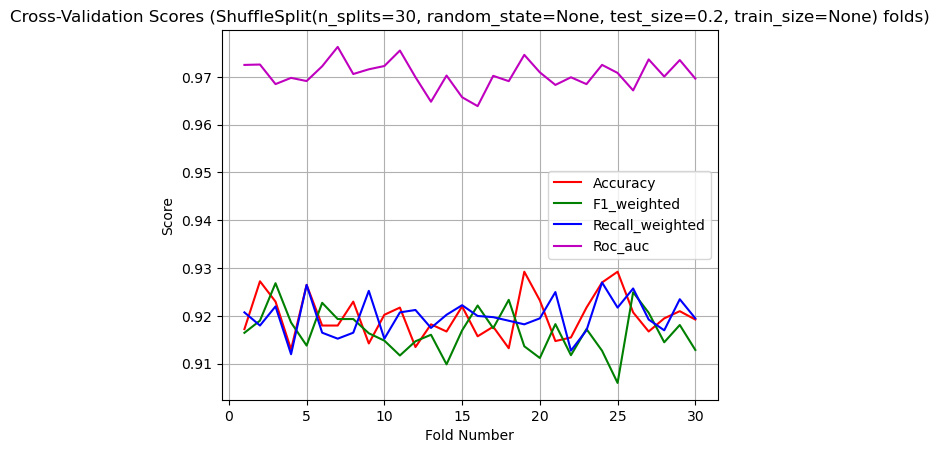

In [15]:
scores_split(model, X_preprocessed, y, cv=random_split)

Using Cross-Validation with KFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.92005
f1_weighted: 0.9193269116552683
recall_weighted: 0.92125
roc_auc: 0.9719169262879184


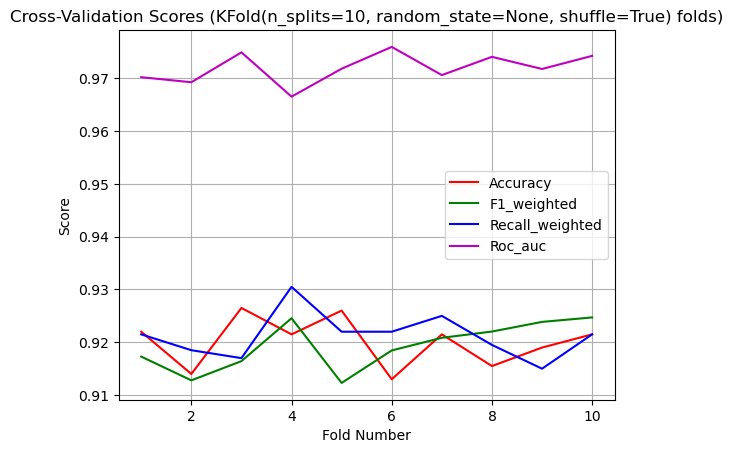

In [16]:
scores_split(model, X_preprocessed, y, cv=kfold)

Using Cross-Validation with StratifiedKFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.9190999999999999
f1_weighted: 0.9194450242825074
recall_weighted: 0.9200999999999999
roc_auc: 0.9709903287350381


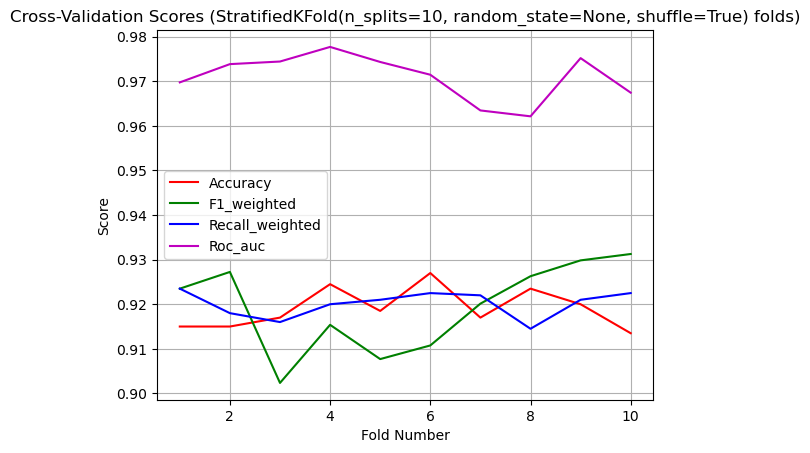

In [17]:
scores_split(model, X_preprocessed, y, cv=stratified_kfold)

In [18]:
# scores_split(model, X_preprocessed, y, cv=loo)

## Tests with Feature Selection

Not Using Train-Test Split
Accuracy:  0.9971
F1:  0.9970958104501644
Recall:  0.9897489539748954
ROC:  0.994578813386922


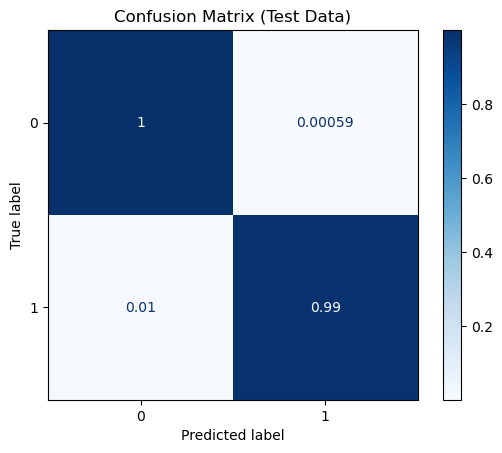

In [20]:
scores_split(model, X_preprocessed, y, feature_selection=True)

Using Train-Test Split
Accuracy:  0.89225
F1:  0.890363967193771
Recall:  0.728125
ROC:  0.8361019736842104


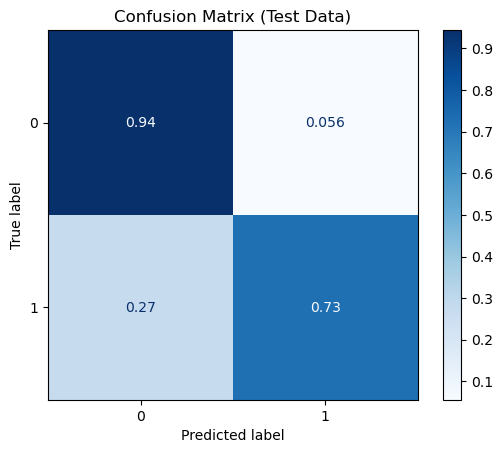

In [22]:
scores_split(model, X_preprocessed, y, test_size=0.4, feature_selection=True)

Using Cross-Validation with ShuffleSplit(n_splits=30, random_state=None, test_size=0.2, train_size=None) folds
accuracy: 0.8892083333333335
f1_weighted: 0.887747678433582
recall_weighted: 0.8888250000000001
roc_auc: 0.9339529255849894


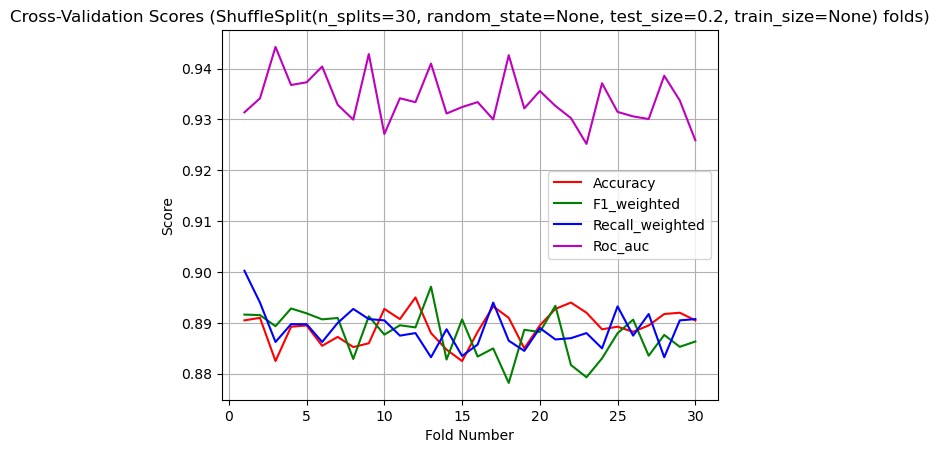

In [29]:
scores_split(model, X_preprocessed, y, cv=random_split, feature_selection=True)

Using Cross-Validation with KFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.891
f1_weighted: 0.8882329831589532
recall_weighted: 0.8904500000000001
roc_auc: 0.935788679908427


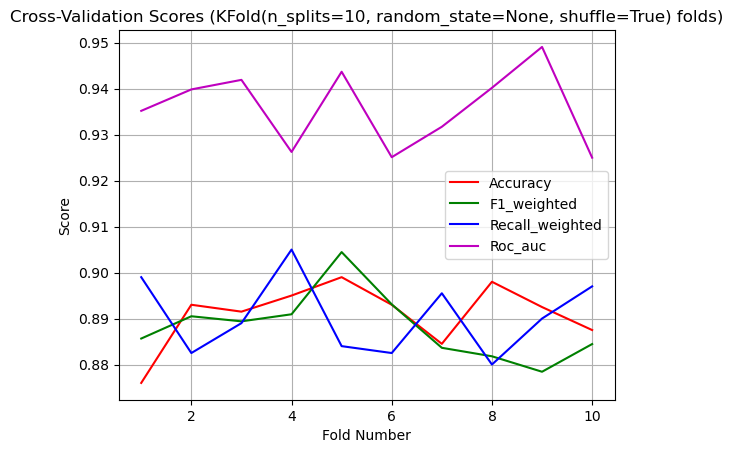

In [30]:
scores_split(model, X_preprocessed, y, cv=kfold, feature_selection=True)

Using Cross-Validation with StratifiedKFold(n_splits=10, random_state=None, shuffle=True) folds
accuracy: 0.88935
f1_weighted: 0.8862218199260468
recall_weighted: 0.8906000000000001
roc_auc: 0.9342310684576007


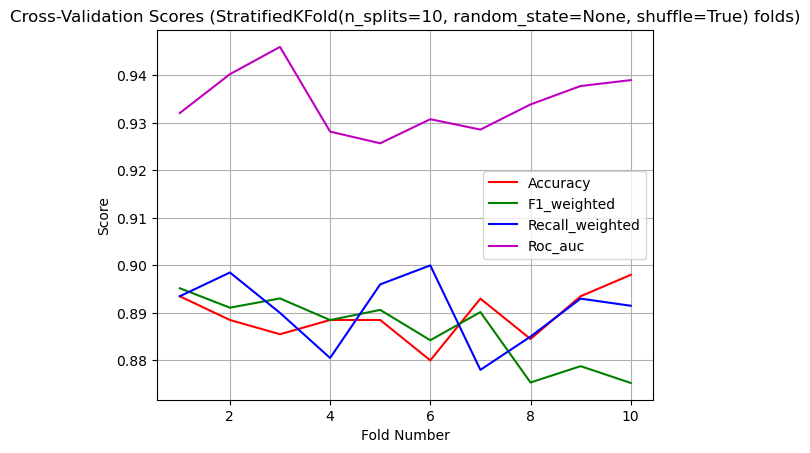

In [31]:
scores_split(model, X_preprocessed, y, cv=stratified_kfold, feature_selection=True)

In [32]:
# scores_split(model, X_preprocessed, y, cv=loo, feature_selection=True)